## Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import r2_score

## Data Pre-Processing

In [3]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=essential_cols, inplace=True)

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
987070             497.48        0.5400         0.462245 -0.78522  0.00590   
1492817            149.10        0.2300         0.221486 -0.85923  0.00050   
1003398            139.15        0.0475         0.099549 -0.00014  0.00006   
587880             186.50        0.1400         0.120490 -0.14843  0.00381   
1076958            172.25        0.2450         0.286875 -0.88395  0.00181   
1283500            161.42        0.1250         0.192881 -0.13575  0.00511   
1419945            122.06        0.1170         0.303564 -0.25038  0.03938   
777115             201.74        0.2125         0.341347 -0.70674  0.01927   
106043             116.55        0.1280         0.358019 -0.74021  0.02083   
387321             324.34        0.1400         0.231506 -0.00742  0.00017   

            vega    theta      rho  equilibrium_price  time_to_expiry  
987070   0.29333 -0.46698 -0.14901             47.990        0.038356

## Black-Scholes Definition

In [ ]:
# Black-Scholes formula for European Put Option
def black_scholes_put(S, K, T, r, sigma):
    """
    S: underlying price
    K: strike price
    T: time to expiry (in years)
    r: risk-free interest rate
    sigma: volatility (standard deviation of log returns)
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # avoid invalid math

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Assumed constant risk-free rate (can be updated if you have data)
risk_free_rate = 0.0243  # 2%

# Apply Black-Scholes formula row-wise
option_df['bs_price'] = option_df.apply(
    lambda row: black_scholes_put(
        S=row['underlying_price'],
        K=row['strike_price'],
        T=row['time_to_expiry'],
        r=risk_free_rate,
        sigma=row['hist_volatility']
    ),
    axis=1
)

print(option_df[['equilibrium_price', 'bs_price']].sample(10))

         equilibrium_price       bs_price
1303968              0.010   0.000000e+00
730154              47.790   0.000000e+00
890110               2.815   0.000000e+00
1013973              0.090   0.000000e+00
335093              15.060  5.533019e-215
1311360              0.095   0.000000e+00
469722              90.475  8.819250e-220
424301              48.600   0.000000e+00
1234491              2.700  3.567055e-295
33133               61.755  1.169800e-207


## Error Analysis


--- Black-Scholes Error Metrics ---
Mean Error: -25.6637
Median Error: nan
Standard Deviation of Error: 39.2327
Mean Absolute Error (MAE): 25.6637
Root Mean Squared Error (RMSE): 46.8811
Mean Absolute Percentage Error (MAPE): inf%
Max Error: 0.0000
Min Error: -520.9950
R² Score: -0.4279


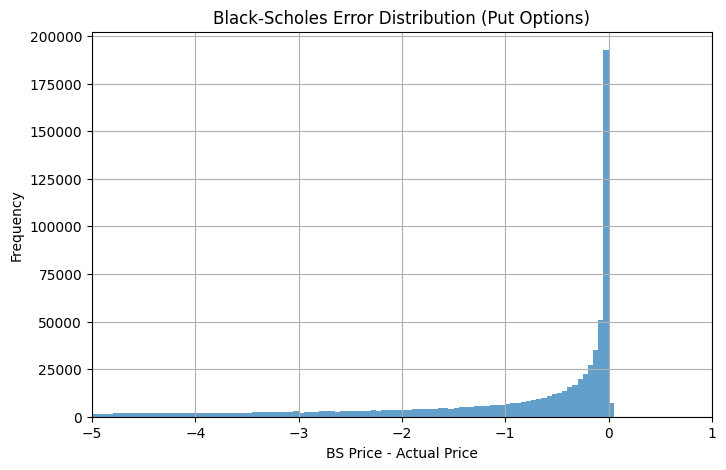

In [11]:
# Difference between predicted and actual prices
bs_diff = option_df['bs_price'] - option_df['equilibrium_price']

# Absolute and percentage errors
abs_error = np.abs(bs_diff)
percent_error = 100 * bs_diff / option_df['equilibrium_price']
abs_percent_error = np.abs(percent_error)

# Compute error metrics
mean_error = bs_diff.mean()
std_error = bs_diff.std()
median_error = np.median(bs_diff)
mae = abs_error.mean()
rmse = np.sqrt(np.mean(bs_diff**2))
mape = abs_percent_error.mean()
max_error = bs_diff.max()
min_error = bs_diff.min()

# R²: drop rows with NaNs
valid = option_df[['equilibrium_price', 'bs_price']].dropna()
r2 = r2_score(valid['equilibrium_price'], valid['bs_price'])

# Print metrics
print("\n--- Black-Scholes Error Metrics ---")
print(f"Mean Error: {mean_error:.4f}")
print(f"Median Error: {median_error:.4f}")
print(f"Standard Deviation of Error: {std_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Max Error: {max_error:.4f}")
print(f"Min Error: {min_error:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot histogram of errors
bins = np.arange(-5, 5, 0.05)

plt.figure(figsize=(8, 5))
plt.hist(bs_diff, bins=bins, alpha=0.7)
plt.xlabel("BS Price - Actual Price")
plt.ylabel("Frequency")
plt.title("Black-Scholes Error Distribution (Put Options)")
plt.xlim([-5, 1])
plt.grid(True)
plt.show()